# First tomography experiments
Konstantin Slavnov, 09/11/2016

**Main Goal:** Find out Matrix factorization approach applicability to tomography tasks

Plan:
* Formulate simple tomography image reconstruction problem
* Develop several methods to solve the problem
    * Based on Matrix factorization technique
    * Based on Manifold learning technique
* Test on simple artificial data and several real snapshots
* Research methods properties
* Make conclusions

## The problem

<font color='red'>**TODO:**</font> https://en.wikipedia.org/wiki/Discrete_tomography

We have an unknown matrix $A \in \mathbb{R}^{n\times m}$. All we have is several projections of $A$. In most simple case we have only sum of elements in each row and column
$$
    r_i = \sum_j A_{ij}, \;  i = 1, \ldots, n \\
    c_j = \sum_i A_{ij}, \;  j = 1, \ldots, m.
$$

Let us illustrate such situation in binary case.

<img src="../imgs/problem_tomography.png", width=400, height=300/>

Now, let write the optimization task, which corresponds to our problem assuming that $A$ — low-rank (k-rank) matrix.

\begin{equation*}
\begin{aligned}
& \underset{A}{\text{minimize}}
& & C\|A \|_1 + \sum_i \left|\xi_i\right| + \sum_j \left|\eta_j\right| \\
& \text{subject to}
& & \sum_j A_{ij} = r_i + \xi_i, \; i = 1, \ldots, n,\\
&&& \sum_i A_{ij} = c_j + \eta_j, \; j = 1, \ldots, m,\\
&&& \mathrm{rank}(A) = k.
\end{aligned}
\end{equation*}

$\xi_i$ and $\eta_j$ was introduced, because we expected some errors in $r_i$, $c_j$ measurement. Or if we have more conditions, it can be impossible to satisfy all of them precisely. So we have mismatch penalty. In most simple case we consider, that $\xi_i=0$, $\eta_j=0$ and also we can put $C=0$.

Another way to work with such problem is to minimize rank directly through rank relaxation function. For example

\begin{equation*}
\begin{aligned}
& \underset{A}{\text{minimize}}
& & \|A \|_* + \sum_i \left|\xi_i\right| + \sum_j \left|\eta_j\right| \\
& \text{subject to}
& & \sum_j A_{ij} = r_i + \xi_i, \; i = 1, \ldots, n,\\
&&& \sum_i A_{ij} = c_j + \eta_j, \; j = 1, \ldots, m,\\
\end{aligned}
\end{equation*}

where $\|A \|_*$ — nuclear norm. "Nuclear norm minimization is a recent heuristic introduced by Fazel in [19], and is an extension of the trace heuristic often used by the control community; see, e.g., [4, 28]. Indeed, when the matrix variable is symmetric and positive semidefinite, the nuclear norm of X is the sum of the (nonnegative) eigenvalues and thus equal to the trace of X. Hence, for positive semidefinite unknowns, (1.5) would simply minimize the trace over the constraint set."  

[source](http://download.springer.com/static/pdf/484/art%253A10.1007%252Fs10208-009-9045-5.pdf?originUrl=http%3A%2F%2Flink.springer.com%2Farticle%2F10.1007%2Fs10208-009-9045-5&token2=exp=1478691603~acl=%2Fstatic%2Fpdf%2F484%2Fart%25253A10.1007%25252Fs10208-009-9045-5.pdf%3ForiginUrl%3Dhttp%253A%252F%252Flink.springer.com%252Farticle%252F10.1007%252Fs10208-009-9045-5*~hmac=3ceced15d68b3db3d199adc29718daf7d73b4c7b13010997eaec80abffe0cf7b)

One another possible optimization task without low-rank assumption:

\begin{equation*}
\begin{aligned}
& \underset{A}{\text{minimize}}
& & \|A \|_1 \\
& \text{subject to}
& & \sum_j A_{ij} = r_i, \; i = 1, \ldots, n,\\
&&& \sum_i A_{ij} = c_j, \; j = 1, \ldots, m.
\end{aligned}
\end{equation*}

### Problem 1

Let us consider most simple case for beginning and let us change absolute value to square

\begin{equation*}
\begin{aligned}
& \underset{A}{\text{minimize}}
& & \sum_i \xi_i^2 + \sum_j \eta_j^2 \\
& \text{subject to}
& & \sum_j A_{ij} = r_i + \xi_i, \; i = 1, \ldots, n,\\
&&& \sum_i A_{ij} = c_j + \eta_j, \; j = 1, \ldots, m,\\
&&& \mathrm{rank}(A) = k.
\end{aligned}
\end{equation*}

<font color='red'>**TODO:**</font> write formulas derivation

So our problem reduced to
$$
e_m^T A^T A e_m + e_n^T A A^T e_n - 2 r^T A e_m - 2 c^T A^T e_n \longrightarrow \min_{A:\,\mathrm{rk}(A)=k}
$$
Let's try to use manifold optimization.

### Solution 1

In [157]:
import numpy as np
from theano import *
import theano.tensor as T
from theano import grad
from theano import function
from pymanopt.manifolds import FixedRankEmbedded, PSDFixedRank
from pymanopt import Problem
from pymanopt.solvers import SteepestDescent, ConjugateGradient, NelderMead

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="white")

In [150]:
U, V = T.dmatrices('U','V')
S = T.dvector('S')
A = U.dot(T.diag(S)).dot(V)

A_init = np.array([[0,0  ,0,0],
                   [0,100,0,0],
                   [0,0,100,0],
                   [0,0,0  ,0]])

r = shared(A_init.sum(axis=1))
c = shared(A_init.sum(axis=0))
L1 = 0.1
z = L1 * A.norm(1) + A.T.dot(A).sum() + A.dot(A.T).sum() - 2 * r.T.dot(A.sum(axis=1)) - 2 * c.T.dot(A.sum(axis=0).T)

cost = function([U, S, V], z)

In [166]:
manifold = FixedRankEmbedded(4, 4, 2)
problem = Problem(manifold=manifold, cost=z, arg=(U, S, V), verbosity=1)
solver = ConjugateGradient()

# let Pymanopt do the rest
Xopt = solver.solve(problem,)

Compiling cost function...
Computing gradient of cost function...
Optimizing...
Terminated - min stepsize reached after 138 iterations, 0.41 seconds.



In [167]:
print("======= SOLUTION =======")
A_res = Xopt[0].dot(np.diag(Xopt[1])).dot(Xopt[2])
print(Ares)
print("row sum:", A_res.sum(axis=1))
print("col sum:", A_res.sum(axis=0))

======= SOLUTION =======
[[-11.48251593  11.99659568  11.88697882 -12.40105836]
 [ 11.81938706  37.65145147  37.76428424  12.76487744]
 [ 11.44565111  38.04191981  38.15118474  12.36124454]
 [-11.78252203  12.31003324  12.1975524  -12.7250634 ]]
row sum: [  6.06688247e-11   9.99767416e+01   9.99690606e+01   7.78793193e-05]
col sum: [  1.29771570e-03   9.99661692e+01   9.99783771e+01   3.59747144e-05]


In [168]:
grad(z, A)

Elemwise{add,no_inplace}.0

So, row and col sums of matrix estimation is really close to initial one.
But matrix is different:

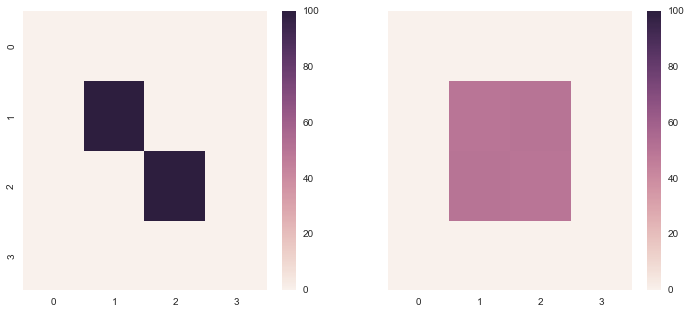

In [169]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True,)
fig.set_figheight(5)
fig.set_figwidth(12)
sns.heatmap(A_init, ax=ax1, vmin=0, vmax=100)
sns.heatmap(A_res, ax=ax2, vmin=0, vmax=100)

Also adding L1 regularization improves quality (you can try to put L1 value to zero and see result)